# All to all network Simulations

We simulate the whole network as an array and we reset it to the initial configuration following a Poisson process

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [26]:
@njit
def init_config(N):
    r = np.random.randint(0, 2, size=N)   # array of 0 or 1
    return 2*r - 1  

@njit
def voter_model_evolution(N, t, r):
    '''Takes:
    N: number of agents
    t: time in MC steps
    r: resetting rate per MC step
    
        Returns:
    config: The config at time t
    res: number of resets'''

    config = init_config(N)
    ini = config.copy()

    res = 0

    for _ in range(t):
        for _ in range(N):
            
            if np.random.rand() < r/N: #Try to reset
                config = ini.copy()
                res = res +1
                continue
            
            a = np.random.randint(N)
            b = np.random.randint(N-1)
            if b >= a:
                b += 1
            
            config[a] = config[b] #If no reset occurs, apply normal VM dynamics

    return(config, res)

## Check Poisson

In [30]:
@njit
def check_poisson(N, T, r, div, samples):
    res = np.zeros(div)

    ts = np.linspace(0, T, div)

    for i in range(div):
        t = ts[i]

        total = 0.0
        for _ in range(samples):
            _, resets = voter_model_evolution(N, int(t), r)
            total += resets

        res[i] = total / samples

    return res

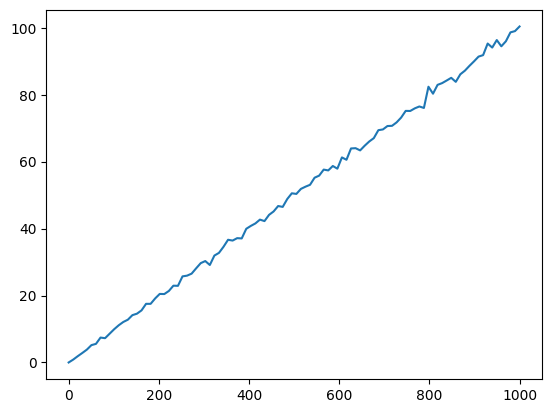

In [32]:
plt.plot(np.linspace(0, 1000, 100), check_poisson(1000, 1000, 0.1, 100, 50))

## Distribution of Magnetisation

In [34]:
@njit
def mag(config):
    return(np.mean(config))

@njit
def dist(N, t, r, samples):
    res = np.zeros(samples)

    for i in range(samples):
        res[i] = mag(voter_model_evolution(N, t, r)[0])
    
    return res

(array([1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00,
        1.0000e+01, 9.0000e+00, 1.5000e+01, 2.0000e+01, 3.5000e+01,
        6.4000e+01, 1.0100e+02, 1.4100e+02, 1.7800e+02, 2.5400e+02,
        4.4800e+02, 5.6800e+02, 8.6300e+02, 1.2340e+03, 1.8670e+03,
        2.4790e+03, 3.8410e+03, 5.2080e+03, 8.0970e+03, 1.0709e+04,
        1.4107e+04, 1.4277e+04, 1.0465e+04, 7.7760e+03, 5.2070e+03,
        3.7560e+03, 2.5570e+03, 1.8850e+03, 1.2210e+03, 8.3300e+02,
        5.5500e+02, 4.0100e+02, 2.8800e+02, 1.6800e+02, 1.3600e+02,
        7.3000e+01, 5.9000e+01, 3.7000e+01, 2.2000e+01, 1.2000e+01,
        4.0000e+00, 7.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-0.962  , -0.92496, -0.88792, -0.85088, -0.81384, -0.7768 ,
        -0.73976, -0.70272, -0.66568, -0.62864, -0.5916 , -0.55456,
        -0.51752, -0.48048, -0.44344, -0.4064 , -0.36936, -0.33232,
        -0.29528, -0.25824, -0.2212 , -0.18416, -0.14712, -0.11008,
        -0.07304, -0.036  ,  0.00104,  0.03808

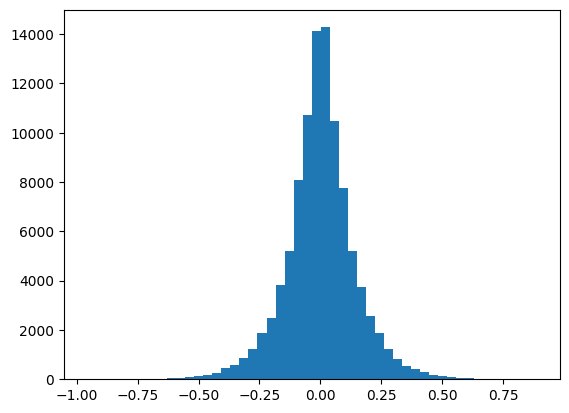

In [38]:
plt.hist(dist(1000, 1000, 0.1, 100000), bins = 50)